# Feature Selection and Training for land classification

- See feature_computation.py for paralelization in Spark.
- Here, we directly import a dataset of 300 000 images with 62 calculated features
- The dataset will be manipulated with pandas and sklearn

First let's import all useful packages

In [1]:
import pywt
import h5py as h5
import numpy as np
from skimage.color import rgb2rgbcie
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier
import itertools
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
PATH_DATA = '../../data/features.h5'
hdf = pd.HDFStore(PATH_DATA)

# Useful list of all the features
features = ["Mean R", "Mean G", "Mean B", "Mean I", "STD R", "STD G", "STD B", "STD I","MOD R", "MOD G", "MOD B" ,"MOD I", "entropy R", "entropy G", "entropy B", "entropy I"] + ["Mean FFT R", "STD FFT R", "Mean FFT G", "STD FFT G", "Mean FFT B", "STD FFT B", "Mean FFT I", "STD FFT I"] + ["MEAN NDVI", " STD NDVI", "MEAN EVI", "STD EVI", "MEAN NDWI", "STD NDWI"] + ["layer1_{}".format(i) for i in range(8)] + ["layer2_{}".format(i) for i in range(8)] + ["layer3_{}".format(i) for i in range(8)] + ["layer4_{}".format(i) for i in range(8)]

# Creation of data frame
df = pd.DataFrame(columns = features)
df = pd.DataFrame(hdf['d1'])



# Useful plot function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Clean the mess
df = df.dropna()
df_train = df.drop(['Label'], axis = 1)

In [6]:
# First Giny feature importances with basic decision tree
tree = DecisionTreeClassifier(max_depth = 20)
tree.fit(train, target)
plt.bar(range(len(tree.feature_importances_)), tree.feature_importances_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

## Preprocessing and Random Forest ##

 Every tree or forest gives feature importances measures of Giny. We can:
 
 - Eliminate an arbitrary percentile of less important features
 - Focus on sub-classification tasks to specialize forest in precise kinds of land recognition

In [19]:
# Preprocessing for new training with fewer features/fewer classes

# Features: keep percentile p given by trained tree or forest feature importances
# (careful: 90 means you take the best 10%, 10 means you take the best 90% f features)
p = 10
imp = np.array(tree.feature_importances_)
dec = np.percentile(imp, p)
indices = [int(i) for i in np.argwhere(imp>dec)]
features_to_keep = [features[i] for i in indices]

# Classes: you may want to focus on a subset of classes to specialize forest in sub-land recognition
classes_to_keep = [4.,5.]
train = df[df['Label'].isin(classes_to_keep)]
target = train['Label']
train = train.drop(['Label'],axis = 1)

train = train[features_to_keep]

In [17]:
# Classification with random forest
X_fit, X_eval, y_fit, y_eval= train_test_split(train, target, test_size=0.2, random_state=1)
rf = RandomForestClassifier(n_estimators = 100, max_depth = 7)
rf.fit(X_fit, y_fit)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

<Container object of 62 artists>

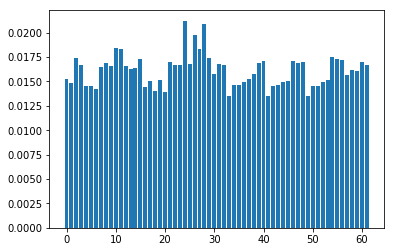

In [41]:
plt.bar(range(len(rf.feature_importances_)), rf.feature_importances_)

In [22]:
y_pred = rf.predict(X_eval)
C = confusion_matrix(y_eval, y_pred)
plot_confusion_matrix(C, classes_to_keep)
print("Accuracy on test: {}".format(accuracy_score(y_eval, y_pred)))

[[7632    0    3  142    0 4529    0    0]
 [2379    0    1   64    0 1511    0    0]
 [4443    0    4  105    0 2644    0    0]
 [4891    0    0  234    0 1797    0    0]
 [1333    0    0   10    1 2265    0    0]
 [6947    0    0  140    0 6246    0    0]
 [1340    0    0    0    1 2262    2    0]
 [1113    0    0   32    0  631    0    0]]
Accuracy on test: 0.26790254639292627


## Balanced dataset ##

 You may want to build a balanced dataset with equal proportion of each class in training set. 
 It has shown better accuracy as Adaboost or Random Forest deals with each category equally 

In [4]:
# Construction of a balanced dataset (population of smallest class applied to every class)

classes_to_keep = [1.,2.,3.,4.,5.,10.,12.,19.,20.]

data_small = df[df.Label.isin(classes_to_keep)]
data_small
name, size = np.unique(data_small["Label"].values, return_counts=True)
n = min(size)
bal = df[df.Label.isin([])]
for i in classes_to_keep:
    bal = pd.concat([bal, data_small[data_small["Label"]==i].sample(n)])
bal.groupby(['Label']).count()

# Prepare learning
target = bal['Label'].values
train = bal.drop(['Label'], axis = 1)
len(target)

81054

In [109]:
# Classification training and test
X_fit, X_eval, y_fit, y_eval= train_test_split(train, target, test_size=0.2, random_state=1)
rf = RandomForestClassifier(n_estimators = 100, max_depth = 20)
rf.fit(X_fit, y_fit)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

<Container object of 62 artists>

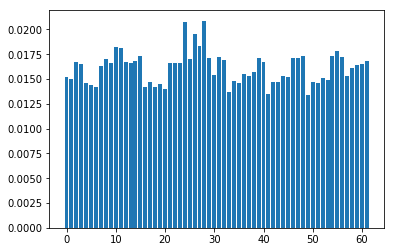

In [110]:
plt.bar(range(len(rf.feature_importances_)), rf.feature_importances_)

Confusion matrix, without normalization
[[208 134 171 154 445 193  97 177 228]
 [193 174 171 191 490 163  88 169 219]
 [182 131 180 182 513 159 111 167 215]
 [116  78  81 560 279 224  69 251 134]
 [188 105 156  82 663 105  92 107 262]
 [111 100 108 372 215 419  87 237 144]
 [142  86 156 241 388 211 115 218 222]
 [119  76  98 306 236 284  78 444 138]
 [134 109 122 146 436 129  85 137 505]]
accuracy 0.20159151193633953


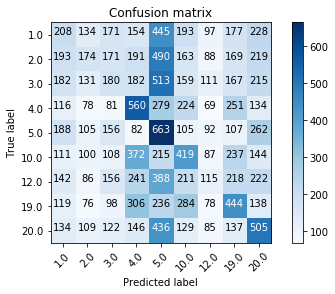

In [111]:
# Prediction
y_pred = rf.predict(X_eval)
C = confusion_matrix(y_eval, y_pred)
plot_confusion_matrix(C, classes_to_keep)
print("accuracy {}".format(accuracy_score(y_eval,y_pred)))

# Only 2 classes and few features

Another interesting point of view is focusing on one class and try to differentiate it with others

**NB**: The large range of features and restricted classification task enables to understad quickly which feature is useful. Then our process:
1. Improves calculation time
2. Gives physical insight to image processing through features which perform optimal classification

In [11]:
# Construction of a balanced dataset (number of smallest class for every class)

classes_to_keep = [4.,5.]

data_small = df[df.Label.isin(classes_to_keep)]
data_small
name, size = np.unique(data_small["Label"].values, return_counts=True)
n = min(size)
bal = df[df.Label.isin([])]
for i in classes_to_keep:
    bal = pd.concat([bal, data_small[data_small["Label"]==i].sample(n)])

# Features: keep percentile p given by trained tree or forest feature importances
# (careful: 90 means you take the best 10%, 10 means you take the best 90% f features)
p = 10
imp = np.array(rf.feature_importances_)
dec = np.percentile(imp, p)
indices = [int(i) for i in np.argwhere(imp>dec)]
features_to_keep = [features[i] for i in indices]

# Balanced training set with selected features and labels
train = bal[bal['Label'].isin(classes_to_keep)]
target = train['Label']
train = train.drop(['Label'],axis = 1)
train = train[features_to_keep]

,Mean R,Mean G,Mean B,Mean I,STD R,STD G,STD B,STD I,MOD R,MOD G,...,layer3_6,layer3_7,layer4_0,layer4_1,layer4_2,layer4_3,layer4_4,layer4_5,layer4_6,layer4_7
Label,,,,,,,,,,,,,,,,,,,,,
5.0,18142,18142,18142,18142,18142,18142,18142,18142,18142,18142,...,18142,18142,18142,18142,18142,18142,18142,18142,18142,18142
10.0,18142,18142,18142,18142,18142,18142,18142,18142,18142,18142,...,18142,18142,18142,18142,18142,18142,18142,18142,18142,18142


In [13]:
# Classification training and test
X_fit, X_eval, y_fit, y_eval= train_test_split(train, target, test_size=0.2, random_state=1)
ada = AdaBoostClassifier(n_estimators = 50, max_depth = 100) # USE CLASS WEIGHT ARGUMENT???
ada.fit(X_fit, y_fit)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

<IPython.core.display.Javascript object>


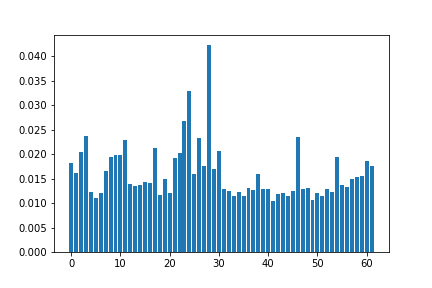

<Container object of 62 artists>

In [14]:
%matplotlib notebook
plt.bar(range(len(ada.feature_importances_)), ada.feature_importances_)

Confusion matrix, without normalization
[[1606  910]
 [ 444 2042]]
accuracy 0.7293082766893243


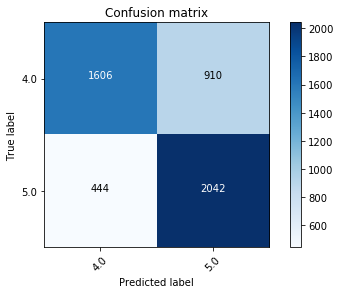

In [151]:
# Prediction
y_pred = ada.predict(X_eval)
C = confusion_matrix(y_eval, y_pred)
plot_confusion_matrix(C, classes_to_keep)
print("accuracy {}".format(accuracy_score(y_eval,y_pred)))